In [1]:
#NOTE was having trouble attaching the video so its in a google drive link in the report
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#variables 
Ks = [2, 3, 10, 20, 40]
stopping_theta = 0.001
seed = 1131
image1= plt.imread("img1lab3.jpg")
image1 = image1.astype(np.float32) / 255.0
image2 = mpl.image.imread("img2lab3.jpeg")
image2 = image2.astype(np.float32) / 255.0
methods = ["random", "random", "spread"]
max_iters=300

In [3]:
def flatten_rgb(img): #flatten to a 2d vector of shape (N,3)
    H,W,three= image.shape
    X=img.reshape(-1,3) #-1 combines the first 2 
    return X, H,W

In [4]:
def unflatten(X, H, W):
    #(N,3) -> (H,W,3)
    return np.clip(X.reshape(H, W, 3), 0.0, 1.0)

In [5]:
#initialization functions 
def init_centers_random(X, K):
    N = X.shape[0] #N is the size 
    indices = np.random.choice(N, K, replace=False) #randomly chooses K, non replaced/unique, indices from 0-N-1
    centers = X[indices] #chosen indices 
    return centers

In [6]:
def init_centers_spread(X, K):
    N = X.shape[0]
    # Randomly pick the first center. index from 0 to size of the flattened 
    first_idx = np.random.randint(0, N)
    centers = [X[first_idx]]
    # Iteratively pick farthest points
    for _ in range(1, K):
        # Compute squared distances from each point to its nearest chosen center
        distances = np.min(np.linalg.norm(X[:,None,:] - np.array(centers)[None,:,:],axis=2),axis=1)
    return np.array(centers)

In [7]:
def euclid(a, b):
    #Return Euclidean distance ||a - b|| for 1D arrays a,b of length 3
    return float(np.linalg.norm(a - b))

In [8]:
def dist_point_to_centers(x, centers):
    #uses euclid to find the distance of the images picture to the og picture
    K = centers.shape[0]
    dists = [0.0] * K
    for k in range(K):
        dists[k] = euclid(x, centers[k])
    return dists
    

In [9]:

def assign_clusters_euclidean(X, centers):
    #Assigns each data point to the nearest center using Euclidean distance
    N = X.shape[0]
    K = centers.shape[0]#amount of centers ->the K
    labels = np.zeros(N, dtype=int) #abels to be assigned 
    #compute the label as it would be the cluster that is the closest
    for i in range(N):
        # Compute Euclidean distance from point i to all K centers
        distances = np.linalg.norm(X[i] - centers, axis=1)
        #the cluster center that it is closest to 
        labels[i] = np.argmin(distances)
    
    return labels

In [10]:
def reseed_empty_center_farthest(X, centers):
    #picks the point in the cluster that is farthest from the center its at currently because there is an empty cluster 
    N = X.shape[0]
    max_min_dist = -1.0 #init
    farthest_idx = 0

    for i in range(N):
        # distance from X[i] to nearest center
        nearest = float("inf") #init before going down 
        for k in range(centers.shape[0]): #go through all of the centers 
            d = euclid(X[i], centers[k])#eucladian distance from x[i] to its nearest current center
            if d < nearest:#keep the smallest dustance 
                nearest = d
        # track the point with largest nearest-center distance
        if nearest > max_min_dist:#if this pixels nearest center distance is the largest
            max_min_dist = nearest#update the largest
            farthest_idx = i

    return X[farthest_idx].copy()

In [11]:
def update_centers_euclidean(X, labels, centers):
    #Recompute centroids and reseed the empty clusters
    K = centers.shape[0]#number of clusters 
    C_new = np.zeros_like(centers)#New centers in the same shaoe as the orginal centers
    counts = np.zeros(K, dtype=int)#one counter per cluster to see how many points assigned to k 

    # sums per cluster
    for i in range(X.shape[0]):#loop over all pixels/data points
        k = labels[i]#cluster that pt i is assigned to 
        C_new[k] += X[i]#add pixel 
        counts[k] += 1 #increment the amount of pixels 

    empty_idx = [] #indexs if 
    for k in range(K):
        if counts[k] > 0:
            C_new[k] /= counts[k] #computes the mean sum/count (updating center)
        else:
            # reseed via farthest-from-nearest-center rule (Euclidean)
            C_new[k] = reseed_empty_center_farthest(X, centers)
            empty_idx.append(k)

    return C_new, empty_idx

In [12]:
def init_centers_random(X, K, seed=None):
    rng = np.random.default_rng(seed) #random number generator
    idx = rng.choice(X.shape[0], K, replace=False) #dont replace 
    return X[idx].copy() #.copty so it ensurese the returned centers are seperate array so later updates dont modify original 

In [13]:
def init_centers_spread(X, K, seed=None):
    #random number 
    rng = np.random.default_rng(seed)
    #N= number of data pts/pixels N,3
    N = X.shape[0]
    centers = np.empty((K, 3), dtype=X.dtype)#array to hold k centers 
    # first center random
    centers[0] = X[rng.integers(0, N)]
    chosen = 1#init amount of centers so fat
    # iteratively add farthest from nearest chosen center
    while chosen < K:
        farthest_idx = 0
        farthest_min_dist = -1.0 #negative 1 incase it rounds to 0 and already close 
        for i in range(N):
            # distance to nearest already-chosen center
            nearest = float("inf")
            for j in range(chosen): #comapre against the already chosen centers
                d = euclid(X[i], centers[j]) #find distance 
                if d < nearest:
                    nearest = d
            if nearest > farthest_min_dist:#if pixel is farthest from nearest center
                farthest_min_dist = nearest
                farthest_idx = i
        centers[chosen] = X[farthest_idx]
        chosen += 1
    return centers #(K,3)

In [14]:
def rmse_pixels(X, Xhat):
    #sqrt(mean(||x - xhat||^2))
    sse = 0.0 #sum of squared error sse 
    for i in range(X.shape[0]):#lloop over all N pixels
        d = X[i] - Xhat[i]
        sse += float(np.dot(d, d))
    return (sse / X.shape[0]) ** 0.5#sqrt 

In [15]:
def run_image (img, img_name="image"):
    X= img.reshape(-1, 3).astype(np.float32) # flatten H×W×3(N,3) also do float32 for math
    H,W= img.shape[:2] # original size

    runs= [] # track of runs
    best_per_k= {} #k with the lowest rmse 

    for K in Ks:# loop over the k 
        for init in methods:# random, random, spread
            # initialize centers 
            if init == "random":#based on the method for that iteratopm 
                centers= init_centers_random(X, K, seed) # pick K random pixels as initial centers
            else:  # "spread"
                centers = init_centers_spread(X, K,seed)

            # rmse
            rmse_prev  = float("inf") # previous iteration RMSE
            rmse_trace = [] #record RMSE/iteration
            converged  = False  # flag when improvement < threshold

            for it in range(1, max_iters + 1):

                labels = assign_clusters_euclidean(X, centers) #nearest center for each pixel
                centers, empties = update_centers_euclidean(X, labels, centers) #mean per cluster

                # reconstruct image + compute RMSE 
                Xhat = np.empty_like(X, dtype=np.float32) # allocate reconstructed (N,3)
                for i in range(X.shape[0]):  # for each pixel
                    Xhat[i] = centers[labels[i]]# replace by its cluster center color
                rmse_curr = rmse_pixels(X, Xhat)# scalar error for this iteration
                rmse_trace.append(rmse_curr)# keep the whole trajectory

                # stopping rule
                if rmse_prev< float("inf"):# skip on very first iteration
                    rel= (rmse_prev - rmse_curr) / rmse_prev if rmse_prev > 0 else 0.0
                    if rel< stopping_theta:# improvement smaller than threshold then stop 
                        converged= True
                        break
                rmse_prev = rmse_curr# carry forward for next iteration to compute the rmse afainst the old 

            # reconstruction image 
            img_rec = np.clip(Xhat.reshape(H, W, 3), 0.0, 1.0)  # back to H×W×3 and clip to valid range

            # orinting for the chart to keep track its all in runs[]
            run_info = {
                "K": K, # number of clusters used
                "init": init, # initialization method name
                "rmse": rmse_curr,# final RMSE (at stop / last iter)
                "iters": len(rmse_trace),# number of iterations executed
                "converged": converged,# True if early-stopped by threshold
                "img_rec": img_rec,# reconstructed image for visualization
                "rmse_trace": rmse_trace,# full per-iteration RMSE curve
            }
            runs.append(run_info) 
            #print so i can put into chart 
            print(f"[{img_name}] K={K:>2}  init={init:<6}  iters={len(rmse_trace):>3}  "
                  f"conv={converged!s:<5}  RMSE={rmse_curr:.6f}")

            # best init for k 
            if (K not in best_per_k) or (rmse_curr < best_per_k[K]["rmse"]):
                best_per_k[K] = run_info

    # plot
    Ks_sorted = sorted(best_per_k.keys(), key=lambda k: Ks.index(k)) 
    n_cols = len(Ks_sorted) + 1 # 1 col for original + one per K
    # original image
    plt.subplot(1, n_cols, 1)
    plt.imshow(img); plt.axis("off")
    plt.title(f"{img_name}: original")

    # best recon per K (choose lowest RMSE among inits)
    for j, K in enumerate(Ks_sorted, start=2):
        r = best_per_k[K]
        plt.subplot(1, n_cols, j)
        plt.imshow(r["img_rec"]); plt.axis("off")
        plt.title(f"K={K}\nRMSE={r['rmse']:.4f}, it={r['iters']}")

    plt.tight_layout(); 
    plt.show()

    return runs, best_per_k


In [16]:
def main():
    print("start")
    runs_img1 = run_image(image1, "image1")
    runs_img2 = run_image(image2, "image2")

start
[image1] K= 2  init=random  iters=  3  conv=True   RMSE=0.199811
[image1] K= 2  init=random  iters=  3  conv=True   RMSE=0.199811
[image1] K= 2  init=spread  iters=  5  conv=True   RMSE=0.199809
[image1] K= 3  init=random  iters=  4  conv=True   RMSE=0.133611
[image1] K= 3  init=random  iters=  4  conv=True   RMSE=0.133611
[image1] K= 3  init=spread  iters=  7  conv=True   RMSE=0.133606
[image1] K=10  init=random  iters= 13  conv=True   RMSE=0.069825
[image1] K=10  init=random  iters= 13  conv=True   RMSE=0.069825
[image1] K=10  init=spread  iters= 16  conv=True   RMSE=0.064909
[image1] K=20  init=random  iters= 42  conv=True   RMSE=0.049111
[image1] K=20  init=random  iters= 42  conv=True   RMSE=0.049111
[image1] K=20  init=spread  iters= 13  conv=True   RMSE=0.048136
[image1] K=40  init=random  iters= 37  conv=True   RMSE=0.039920
[image1] K=40  init=random  iters= 37  conv=True   RMSE=0.039920
[image1] K=40  init=spread  iters= 20  conv=True   RMSE=0.036089


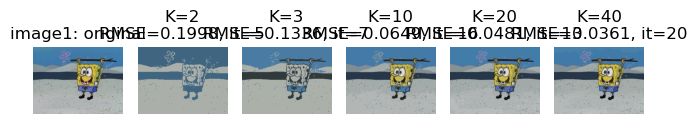

[image2] K= 2  init=random  iters=  4  conv=True   RMSE=0.225913
[image2] K= 2  init=random  iters=  4  conv=True   RMSE=0.225913
[image2] K= 2  init=spread  iters=  4  conv=True   RMSE=0.225914
[image2] K= 3  init=random  iters= 10  conv=True   RMSE=0.155681
[image2] K= 3  init=random  iters= 10  conv=True   RMSE=0.155681
[image2] K= 3  init=spread  iters=  8  conv=True   RMSE=0.155680
[image2] K=10  init=random  iters=  7  conv=True   RMSE=0.061013
[image2] K=10  init=random  iters=  7  conv=True   RMSE=0.061013
[image2] K=10  init=spread  iters=  6  conv=True   RMSE=0.070417
[image2] K=20  init=random  iters= 32  conv=True   RMSE=0.044467
[image2] K=20  init=random  iters= 32  conv=True   RMSE=0.044467
[image2] K=20  init=spread  iters= 17  conv=True   RMSE=0.044296
[image2] K=40  init=random  iters= 23  conv=True   RMSE=0.033859
[image2] K=40  init=random  iters= 23  conv=True   RMSE=0.033859


In [ ]:
main()